In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import optuna

sys.path.append(os.path.abspath(os.path.join('..')))

from src.utils import load_data, evaluate_model, compare_models

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\Users\NIKHIL AGRAWAL\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_data('../data/raw/covtype.csv')
print(df.info())
target = 'Cover_Type'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

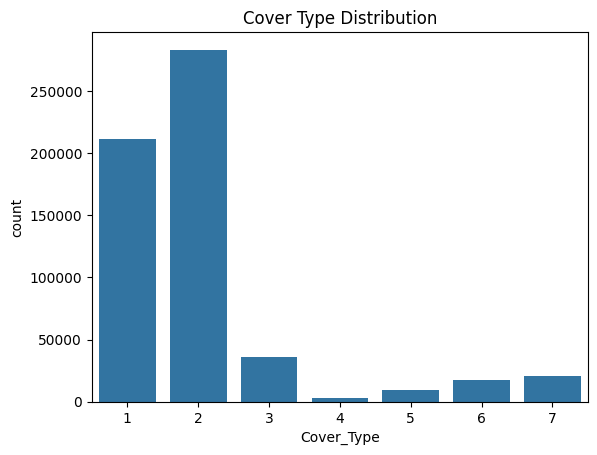

In [3]:
sns.countplot(x=target, data=df)
plt.title('Cover Type Distribution')
plt.show()

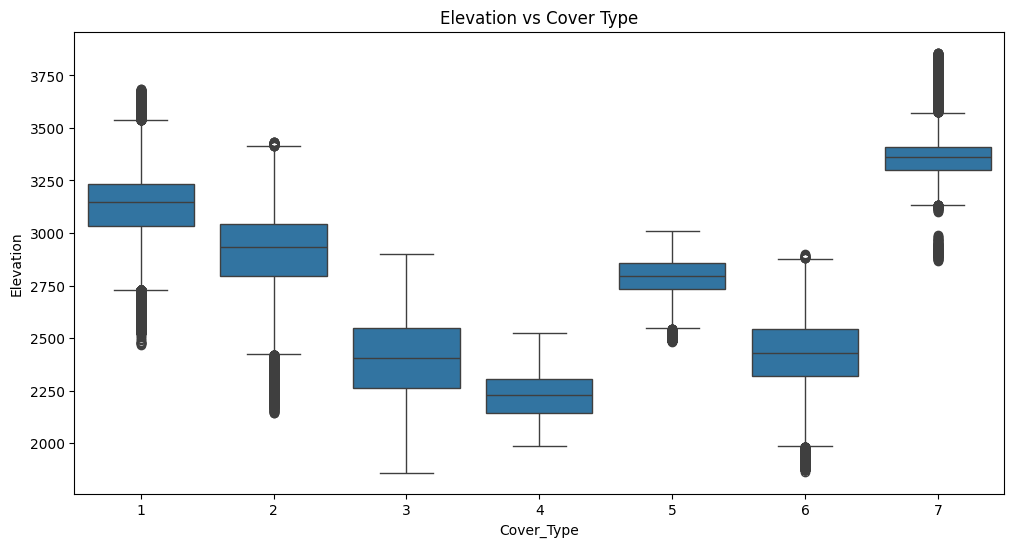

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=target, y='Elevation', data=df)
plt.title('Elevation vs Cover Type')
plt.show()

In [5]:
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

X = df.drop(target, axis=1)
y = df[target]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print("Preprocessing data...")
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

Preprocessing data...


In [6]:
# Universal Subsampling for Tuning Phase
# We use a fixed subset of 20,000 samples for all hyperparameter searches to ensure speed.
tuning_size = 20000
idx_tune = np.random.choice(len(X_train), size=tuning_size, replace=False)
X_tune = X_train[idx_tune]
y_tune = y_train.iloc[idx_tune]

print(f"Tuning on subset of {tuning_size} samples for speed.")

Tuning on subset of 20000 samples for speed.


In [7]:
# === 1. SVM Optimization ===
# def objective_svm(trial):
#     C = trial.suggest_float('C', 1e-3, 1e2, log=True)
#     # Limiting to RBF as it's generally best for non-linear tabular data
#     clf = SVC(C=C, kernel='rbf', gamma='scale', random_state=42)
#     score = cross_val_score(clf, X_tune, y_tune, cv=3, scoring='f1_weighted', n_jobs=-1).mean()
#     return score
# 
# print("Tuning SVM...")
# study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study_svm.optimize(objective_svm, n_trials=10) # Low trials due to high cost of SVM
# print("Best SVM Params:", study_svm.best_params)
# best_svm = SVC(**study_svm.best_params, kernel='rbf', random_state=42)

# Reverting to untuned model as requested
print("Skipping SVM Tuning (Reverted to Default)")
best_svm = SVC(kernel='rbf', random_state=42)

Skipping SVM Tuning (Reverted to Default)


In [8]:
# === 2. Random Forest Optimization ===
# def objective_rf(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 5, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     
#     clf = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42,
#         n_jobs=-1
#     )
#     score = cross_val_score(clf, X_tune, y_tune, cv=3, scoring='f1_weighted', n_jobs=-1).mean()
#     return score
# 
# print("Tuning Random Forest...")
# study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study_rf.optimize(objective_rf, n_trials=15)
# print("Best RF Params:", study_rf.best_params)
# best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)

# Reverting to untuned model as requested
print("Skipping RF Tuning (Reverted to Default)")
best_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

Skipping RF Tuning (Reverted to Default)


In [9]:
# === 3. KNN Optimization ===
# def objective_knn(trial):
#     n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     p = trial.suggest_categorical('p', [1, 2]) # 1=Manhattan, 2=Euclidean
#     
#     clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p, n_jobs=-1)
#     score = cross_val_score(clf, X_tune, y_tune, cv=3, scoring='f1_weighted', n_jobs=-1).mean()
#     return score
# 
# print("Tuning KNN...")
# study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study_knn.optimize(objective_knn, n_trials=15)
# print("Best KNN Params:", study_knn.best_params)
# best_knn = KNeighborsClassifier(**study_knn.best_params, n_jobs=-1)

# Reverting to untuned model as requested
print("Skipping KNN Tuning (Reverted to Default)")
best_knn = KNeighborsClassifier(n_jobs=-1)

Skipping KNN Tuning (Reverted to Default)


Starting Final Training...
Training Logistic Regression...


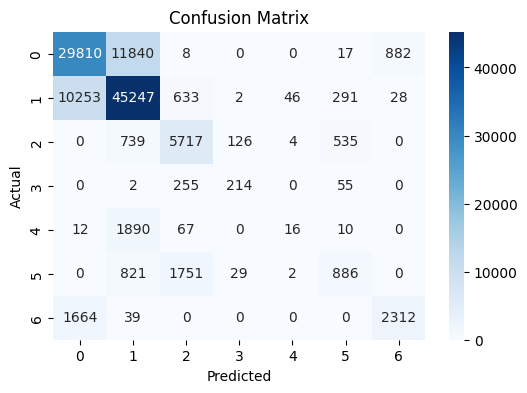

Training KNN...


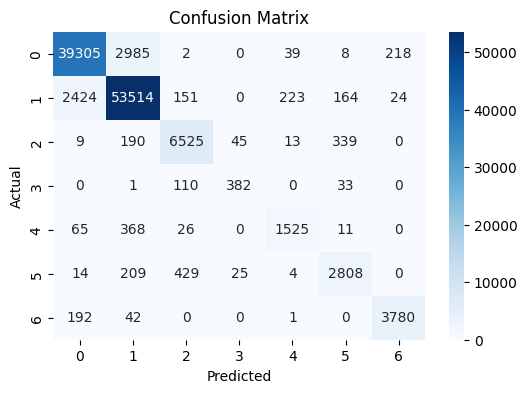

Training Decision Tree...


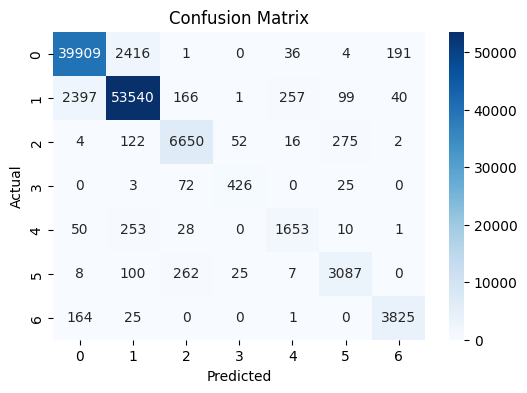

Training Random Forest...


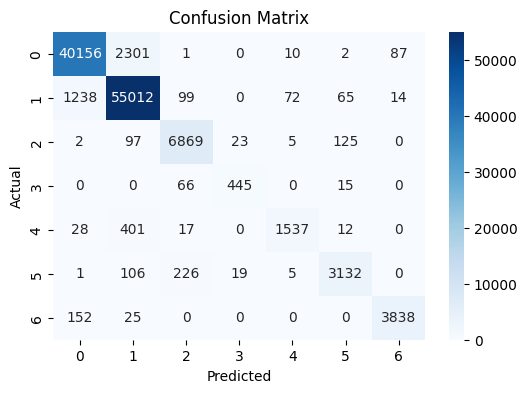

Training MLP...


C:\Users\NIKHIL AGRAWAL\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


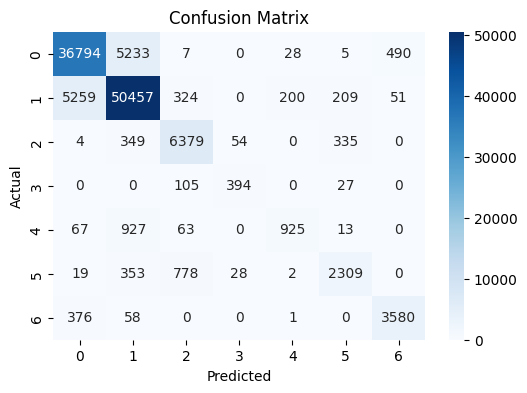

Training SVM...


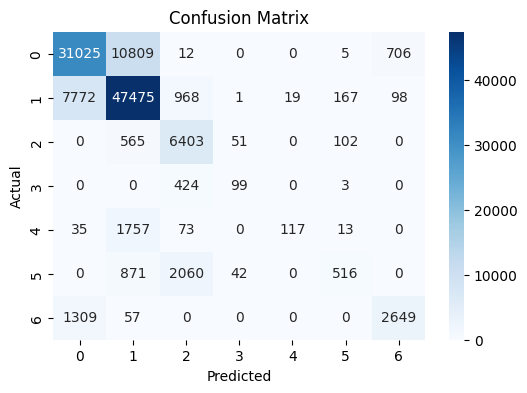

In [10]:
# Final Training Dictionary
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': best_knn,
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': best_rf,
    'MLP': MLPClassifier(random_state=42, max_iter=200),
    'SVM': best_svm
}

results = {}
trained_models = {}

print("Starting Final Training...")
train_subset_size = 50000 # Use larger subset for final training to keep it reasonable

for name, model in models.items():
    print(f"Training {name}...")
    
    # SVM and KNN can be very slow on 400k+ rows. We train on a larger subset for them.
    # RF and Decision Tree can technically handle the full set, but for consistency/speed in this demo we use the subset.
    # You can increase train_subset_size if you have time/compute.
    if 'SVM' in name:
        idx = np.random.choice(len(X_train), size=train_subset_size, replace=False)
        model.fit(X_train[idx], y_train.iloc[idx])
    else:
        model.fit(X_train, y_train)
        
    results[name] = evaluate_model(model, X_test, y_test, is_binary=False)
    trained_models[name] = model

In [11]:
df_results = compare_models(results)
print(df_results)

                     Accuracy  Precision    Recall        F1
Random Forest        0.955130   0.955244  0.955130  0.954888
Decision Tree        0.938788   0.938763  0.938788  0.938771
KNN                  0.928023   0.927756  0.928023  0.927785
MLP                  0.867774   0.866978  0.867774  0.866310
SVM                  0.759739   0.760484  0.759739  0.746773
Logistic Regression  0.724611   0.712554  0.724611  0.714467


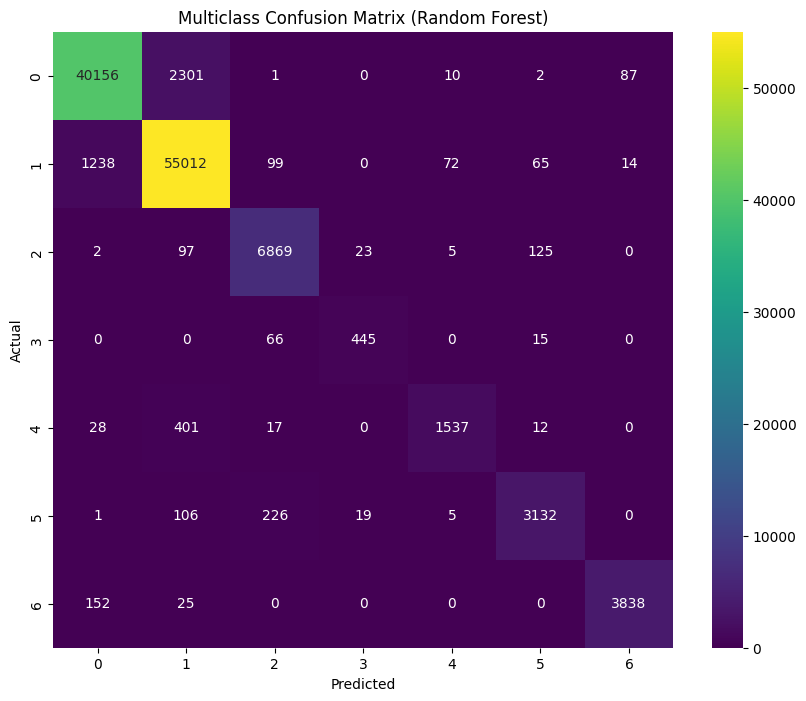

In [12]:
best_model_name = df_results.index[0]
best_model = trained_models[best_model_name]

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title(f'Multiclass Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()